<a href="https://colab.research.google.com/github/MartaKow/ACR-HR-test-analysis/blob/main/ACR_HR_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import glob
import os
import json
from IPython.display import display as d

import pandas as pd
import numpy as np
import math

**Wgranie pliku wyników**

In [ ]:
df = pd.read_excel("WynikiACR_HR.xlsx")
d(df.head())

,uczestnik_ID,ocena,gif_nazwa,scena,funkcja
0,1,2,gosia_1f,1,1
1,1,5,mateusz_3f,2,3
2,1,4,victor_0,3,0
3,1,2,damian_0,4,0
4,1,3,damian_1f,4,1


**1. Obliczenie wartości MOS i zakresu ±2×std dla każdego pliku testowego**

In [ ]:
mos_per_video = df.groupby(by="gif_nazwa").mean().reset_index()[["gif_nazwa", "ocena"]]
mos_per_video = mos_per_video.rename(columns={"ocena": "MOS"})

std_per_video = df.groupby(["gif_nazwa"])["ocena"].std().reset_index()[["gif_nazwa", "ocena"]]
std_per_video = std_per_video.rename(columns={"ocena": "std"})

std_mean = pd.merge(mos_per_video, std_per_video, left_on="gif_nazwa", right_on="gif_nazwa")

# std_mean["-2xstd"] = std_mean["MOS"] - 2*(std_mean["std"])
# std_mean["+2xstd"] = std_mean["MOS"] + 2*(std_mean["std"])

std_mean["limit_dolny"] = std_mean["MOS"] - 2*(std_mean["std"])
std_mean["limit_gorny"] = std_mean["MOS"] + 2*(std_mean["std"])
d(std_mean)

# std_mean.to_csv('tabela1.csv')

,gif_nazwa,MOS,std,limit_dolny,limit_gorny
0,damian_0,3.924731,1.163172,1.598388,6.251075
1,damian_1f,3.204301,1.363811,0.476678,5.931924
2,damian_2f,3.774194,1.124133,1.525928,6.022459
3,damian_3f,3.483871,1.128802,1.226267,5.741475
4,gosia_0,3.709677,1.264745,1.180188,6.239167
5,gosia_1f,2.978495,1.151355,0.675784,5.281206
6,gosia_2f,3.537634,1.238505,1.060625,6.014644
7,gosia_3f,3.473118,1.273402,0.926315,6.019922
8,mateusz_0,3.344086,1.485397,0.373292,6.314880
9,mateusz_1f,3.333333,1.262617,0.808098,5.858568


**2. Weryfikowanie ocen:**
Gdy więcej niż 5% odpowiedzi danego uczestnika leży poza zakresem ±2× std (w tym wypadku co najmniej jedna odpowiedź) to odpowiedzi są nieistotne statystycznie. Oceny osób z listy nieistotne usuwane są z dalszej analizy.

In [ ]:
u = 93 #uczestnicy
nieistotne = []

for i in range (u):
  for j in range (len(std_mean["gif_nazwa"])):
    if df.loc[(df["uczestnik_ID"]==i+1) & (df["gif_nazwa"]==std_mean.gif_nazwa[j])]["ocena"].values[0] < std_mean.limit_dolny[j]:
      nieistotne.append(i+1)
      break
    # if df.loc[(df["uczestnik_ID"]==i+1) & (df["gif_nazwa"]==std_mean.gif_nazwa[j])]["ocena"].values[0] > std_mean.limit_gorny[j]:
    #   nieistotne.append(i+1)
    #   break

print("Liczba osób, które udzieliły nieistotnych statystycznie odpowiedzi: ", len(nieistotne))
#print(nieistotne)

df2 = df[df.uczestnik_ID.isin(nieistotne) == False]
# d(df2.head(30))

Liczba osób, które udzieliły nieistotnych statystycznie odpowiedzi:  28


**3. Obliczenie wartości DMOS** dla każdej pojedynczej oceny

In [ ]:
#zmaina ID uczestnika w zależności od występowania:
pd.options.mode.chained_assignment = None
IDuczestnikow = df2['uczestnik_ID'].unique().tolist()
i=1
for item in IDuczestnikow:
  df2["uczestnik_ID"].replace({item : i}, inplace = True)
  i = i+1 

u = len(IDuczestnikow) #nowa liczba uczestnikow
dmos = df2

for i in range (u):
  for j in range (4): #iteracja po scenach
    ocena_f1 = dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==1)]["ocena"].values[0]
    ocena_f2 = dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==2)]["ocena"].values[0]
    ocena_f3 = dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==3)]["ocena"].values[0]
    ocena_0 = dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==0)]["ocena"].values[0]

    dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==1), "DMOS"] = ocena_f1 - ocena_0
    dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==2), "DMOS"] = ocena_f2 - ocena_0
    dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==3), "DMOS"] = ocena_f3 - ocena_0
    dmos.loc[(dmos["uczestnik_ID"]==i+1) & (dmos["scena"]==j+1) & (dmos["funkcja"]==0), "DMOS"] = 0

d(dmos.head())

,uczestnik_ID,ocena,gif_nazwa,scena,funkcja,DMOS
16,1,3,gosia_1f,1,1,1.0
17,1,3,mateusz_3f,2,3,1.0
18,1,4,victor_0,3,0,0.0
19,1,5,damian_0,4,0,0.0
20,1,4,damian_1f,4,1,-1.0


**Obliczenie wartości średniej DMOS** dla każdego testowanego pliku

In [ ]:
meandmos_per_video = dmos.groupby(by="gif_nazwa").mean().reset_index()[["gif_nazwa", "DMOS"]]
meandmos_per_video = meandmos_per_video.rename(columns={"DMOS": "mean_DMOS"})
d(meandmos_per_video)

# meandmos_per_video.to_csv('tabela2.csv')

,gif_nazwa,mean_DMOS
0,damian_0,0.000000
1,damian_1f,-0.615385
2,damian_2f,-0.153846
3,damian_3f,-0.461538
4,gosia_0,0.000000
5,gosia_1f,-0.707692
6,gosia_2f,-0.030769
7,gosia_3f,-0.107692
8,mateusz_0,0.000000
9,mateusz_1f,0.138462


**4. Test [t-studenta](https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/) na równość średnich ocen funkcji**


In [ ]:
from scipy import stats 
from scipy.stats import t
from scipy.stats import shapiro

oceny_f1 = []
oceny_f2 = []
oceny_f3 = []

oceny_f1 = dmos.loc[(dmos["funkcja"]==1)]["DMOS"]
oceny_f2 = dmos.loc[(dmos["funkcja"]==2)]["DMOS"]
oceny_f3 = dmos.loc[(dmos["funkcja"]==3)]["DMOS"]

# sprawdzenie założenia o normalności rozkładu zmiennej -> test Shapiro-Wilka
if shapiro(oceny_f1).pvalue < 0.05:
  print ("Rozkład normalny dla funkcji 1.")
if shapiro(oceny_f2).pvalue < 0.05:
  print ("Rozkład normalny dla funkcji 2.")
if shapiro(oceny_f3).pvalue < 0.05:
  print ("Rozkład normalny dla funkcji 3.")

# Test Levene’a na jednorodność wariancji
if stats.levene(oceny_f1, oceny_f2, oceny_f3, center='median').pvalue > 0.05:
  print ("Brak istotnej różnicy wariancji pomiędzy grupami")

Rozkład normalny dla funkcji 1.
Rozkład normalny dla funkcji 2.
Rozkład normalny dla funkcji 3.
Brak istotnej różnicy wariancji pomiędzy grupami


In [ ]:
mean_oceny_f1, mean_oceny_f2, mean_oceny_f3 = np.mean(oceny_f1), np.mean(oceny_f2), np.mean(oceny_f3)
n1, n2, n3 = len(oceny_f1), len(oceny_f2), len(oceny_f3)
std1, std2, std3 = np.std(oceny_f1, ddof=1), np.std(oceny_f2, ddof=1), np.std(oceny_f3, ddof=1)
std_error_f1, std_error_f2, std_error_f3 = std1/np.sqrt(n1), std2/np.sqrt(n2), std3/np.sqrt(n3)

# standard error on the difference between the samples:
sed_f12 = np.sqrt(std_error_f1**2.0 + std_error_f2**2.0)
sed_f13 = np.sqrt(std_error_f1**2.0 + std_error_f3**2.0)
sed_f23 = np.sqrt(std_error_f2**2.0 + std_error_f3**2.0)

# calculate the t statistic:
t_stat_f12 = (mean_oceny_f1 - mean_oceny_f2) / sed_f12
t_stat_f13 = (mean_oceny_f1 - mean_oceny_f3) / sed_f13
t_stat_f23 = (mean_oceny_f2 - mean_oceny_f3) / sed_f23

# degrees of freedom
df_f12 = n1 + n2 - 2
df_f13 = n1 + n3 - 2
df_f23 = n2 + n3 - 2

# calculate the critical value
alpha = 0.05
cv_f12 = t.ppf(1.0 - alpha, df_f12)
cv_f13 = t.ppf(1.0 - alpha, df_f13)
cv_f23 = t.ppf(1.0 - alpha, df_f23)

# calculate the p-value
p_f12 = (1 - t.cdf(abs(t_stat_f12), df_f12)) * 2
p_f13 = (1 - t.cdf(abs(t_stat_f13), df_f13)) * 2
p_f23 = (1 - t.cdf(abs(t_stat_f23), df_f23)) * 2

# porównanie f1 i f2
if abs(t_stat_f12) <= cv_f12:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest fałszywa.')
if p_f12 > alpha:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest fałszywa.')

# porównanie f1 i f3
if abs(t_stat_f13) <= cv_f13:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest fałszywa.')
if p_f13 > alpha:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest fałszywa.')

# porównanie f2 i f3
if abs(t_stat_f23) <= cv_f23:
	print('Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest fałszywa.')
if p_f23 > alpha:
	print('Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest fałszywa.')


print(mean_oceny_f1, mean_oceny_f2, mean_oceny_f3, t_stat_f23, p_f23)

Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla funkcji 1 i 2 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla funkcji 1 i 3 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla funkcji 2 i 3 są równe jest prawdziwa.
-0.3 0.1 -0.03076923076923077 1.0778829190208008 0.28158769982384024


Ocena wielkości **efektu** (wg [d Cohena](https://dfrieds.com/math/effect-size.html))

*   0,20 - 0,49 - mała różnica
*   0,50 - 0,79 - przeciętna różnica
*   od 0,80 - duża różnica

In [ ]:
# wariancja łączna
pooled_std_f12 = math.sqrt(((n1 - 1)*std1 * std1 + (n2-1)*std2 * std2) / (n1 + n2-2))
pooled_std_f13 = math.sqrt(((n1 - 1)*std1 * std1 + (n3-1)*std3 * std3) / (n1 + n3-2))
pooled_std_f23 = math.sqrt(((n2 - 1)*std2 * std2 + (n3-1)*std3 * std3) / (n2 + n3-2))

efekt_f12 = abs((mean_oceny_f1 - mean_oceny_f2) / pooled_std_f12)
efekt_f13 = abs((mean_oceny_f1 - mean_oceny_f3) / pooled_std_f13)
efekt_f23 = abs((mean_oceny_f2 - mean_oceny_f3) / pooled_std_f23)

print('Wielkość efektu dla funkcji 1 i 2 =', np.round(efekt_f12,3))
print('Wielkość efektu dla funkcji 1 i 3 =', np.round(efekt_f13,3))
print('Wielkość efektu dla funkcji 2 i 3 =', np.round(efekt_f23,3))

Wielkość efektu dla funkcji 1 i 2 = 0.283
Wielkość efektu dla funkcji 1 i 3 = 0.191
Wielkość efektu dla funkcji 2 i 3 = 0.095


Wykres rozkładu ocen dla każdej z trzech funkcji -> Funkcja gęstości prowdopodobieństwa:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

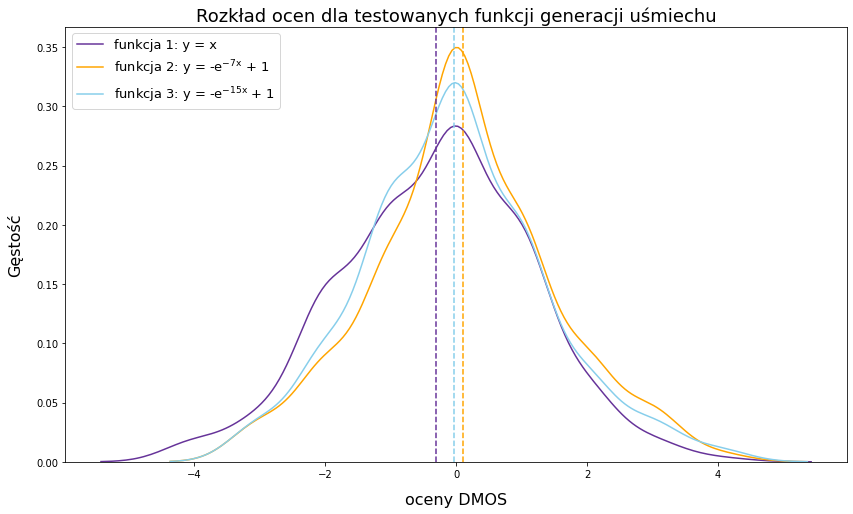

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 8))
sns.distplot(oceny_f1, hist=False, color='rebeccapurple', label="funkcja 1: y = x")
sns.distplot(oceny_f2, hist=False, color='orange', label="funkcja 2: y = -$\mathregular{e^{-7x}}$ + 1")
sns.distplot(oceny_f3, hist=False, color='skyblue', label="funkcja 3: y = -$\mathregular{e^{-15x}}$ + 1")

# zaznaczenie średniej ocen na wykresie
plt.axvline(x=mean_oceny_f1, color='rebeccapurple', linestyle='--')
plt.axvline(x=mean_oceny_f2, color='orange', linestyle='--')
plt.axvline(x=mean_oceny_f3, color='skyblue', linestyle='--')

plt.xlabel("oceny DMOS", labelpad=13, fontsize=16)
plt.ylabel("Gęstość", labelpad=13, fontsize=16)
plt.title("Rozkład ocen dla testowanych funkcji generacji uśmiechu", fontsize=18);
plt.legend(loc="upper left", fontsize=13)

# plt.savefig('rozklad_gestosci.png')

**5. Test t-studenta na równość średnich ocen scen**


In [ ]:
oceny_s1 = []
oceny_s2 = []
oceny_s3 = []
oceny_s4 = []

oceny_s1 = dmos.loc[(dmos["scena"]==1) & (dmos["funkcja"]==2)]["DMOS"]
oceny_s2 = dmos.loc[(dmos["scena"]==2) & (dmos["funkcja"]==2)]["DMOS"]
oceny_s3 = dmos.loc[(dmos["scena"]==3) & (dmos["funkcja"]==2)]["DMOS"]
oceny_s4 = dmos.loc[(dmos["scena"]==4) & (dmos["funkcja"]==2)]["DMOS"]

mean_oceny_s1, mean_oceny_s2, mean_oceny_s3, mean_oceny_s4 = np.mean(oceny_s1), np.mean(oceny_s2), np.mean(oceny_s3), np.mean(oceny_s4)
n1, n2, n3, n4 = len(oceny_s1), len(oceny_s2), len(oceny_s3), len(oceny_s4)
std_s1, std_s2, std_s3, std_s4 = np.std(oceny_s1, ddof=1), np.std(oceny_s2, ddof=1), np.std(oceny_s3, ddof=1), np.std(oceny_s4, ddof=1)
std_error_s1, std_error_s2, std_error_s3, std_error_s4 = std_s1/np.sqrt(n1), std_s2/np.sqrt(n2), std_s3/np.sqrt(n3), std_s4/np.sqrt(n4)

# standard error on the difference between the samples:
sed_s12 = np.sqrt(std_error_s1**2.0 + std_error_s2**2.0)
sed_s13 = np.sqrt(std_error_s1**2.0 + std_error_s3**2.0)
sed_s14 = np.sqrt(std_error_s1**2.0 + std_error_s4**2.0)
sed_s23 = np.sqrt(std_error_s2**2.0 + std_error_s3**2.0)
sed_s24 = np.sqrt(std_error_s2**2.0 + std_error_s4**2.0)
sed_s34 = np.sqrt(std_error_s3**2.0 + std_error_s4**2.0)

# calculate the t statistic:
t_stat_s12 = (mean_oceny_s1 - mean_oceny_s2) / sed_s12
t_stat_s13 = (mean_oceny_s1 - mean_oceny_s3) / sed_s13
t_stat_s14 = (mean_oceny_s1 - mean_oceny_s4) / sed_s14
t_stat_s23 = (mean_oceny_s2 - mean_oceny_s3) / sed_s23
t_stat_s24 = (mean_oceny_s2 - mean_oceny_s4) / sed_s24
t_stat_s34 = (mean_oceny_s3 - mean_oceny_s4) / sed_s34

# degrees of freedom
df_s12 = n1 + n2 - 2
df_s13 = n1 + n3 - 2
df_s14 = n1 + n4 - 2
df_s23 = n2 + n3 - 2
df_s24 = n2 + n4 - 2
df_s34 = n3 + n4 - 2

# calculate the critical value
alpha = 0.05
cv_s12 = t.ppf(1.0 - alpha, df_s12)
cv_s13 = t.ppf(1.0 - alpha, df_s13)
cv_s14 = t.ppf(1.0 - alpha, df_s14)
cv_s23 = t.ppf(1.0 - alpha, df_s23)
cv_s24 = t.ppf(1.0 - alpha, df_s24)
cv_s34 = t.ppf(1.0 - alpha, df_s34)

# calculate the p-value
p_s12 = (1 - t.cdf(abs(t_stat_s12), df_s12)) * 2
p_s13 = (1 - t.cdf(abs(t_stat_s13), df_s13)) * 2
p_s14 = (1 - t.cdf(abs(t_stat_s14), df_s14)) * 2
p_s23 = (1 - t.cdf(abs(t_stat_s23), df_s23)) * 2
p_s24 = (1 - t.cdf(abs(t_stat_s24), df_s24)) * 2
p_s34 = (1 - t.cdf(abs(t_stat_s34), df_s34)) * 2

# gdyby wariancje miały stosunek większy niż 4:1 to zamaist testu t-studenta test-welcha
# print(np.var(oceny_s1), np.var(oceny_s2),np.var(oceny_s3), np.var(oceny_s4))
#test Levene na jednorodność wariancji, jak p-value wyjdzie mniejsze niż 0,05 to nie są jednorodne:
# print(stats.levene(oceny_s1, oceny_s2, oceny_s3, oceny_s4))

# porównanie s1 i s2
# dla obu sprawdzeń powinna być ta sama decyzja, a dla tych dwóch scen nie ma i nie wiem jak to interpretować
if abs(t_stat_s12) <= cv_s12:
	print('Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest fałszywa.')
if p_s12 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest fałszywa.')

# porównanie s1 i s3
if abs(t_stat_s13) <= cv_s13:
	print('Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest fałszywa.')
if p_s13 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest fałszywa.')
 
# porównanie s1 i s4
if abs(t_stat_s14) <= cv_s14:
	print('Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest fałszywa.')
if p_s14 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest fałszywa.')
 
# porównanie s2 i s3
if abs(t_stat_s23) <= cv_s23:
	print('Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest fałszywa.')
if p_s23 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest fałszywa.')

# porównanie s2 i s4
if abs(t_stat_s24) <= cv_s24:
	print('Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest fałszywa.')
if p_s24 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest fałszywa.')
 
# porównanie s3 i s4
if abs(t_stat_s34) <= cv_s34:
	print('Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest fałszywa.')
if p_s34 > alpha:
	print('Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest prawdziwa.')
else:
	print('Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest fałszywa.')

Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla scen 1 i 2 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 1 i 3 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 1 i 4 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 2 i 3 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla scen 2 i 4 są równe jest fałszywa.
Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest prawdziwa.
Hipoteza zerowa, że średnie dla scen 3 i 4 są równe jest prawdziwa.


**ANOVA**: Sprawdzenie istotności różnic średnich ocen w zależności od testowanej sceny

Spełnione


Text(0, 0.5, 'numer sceny')

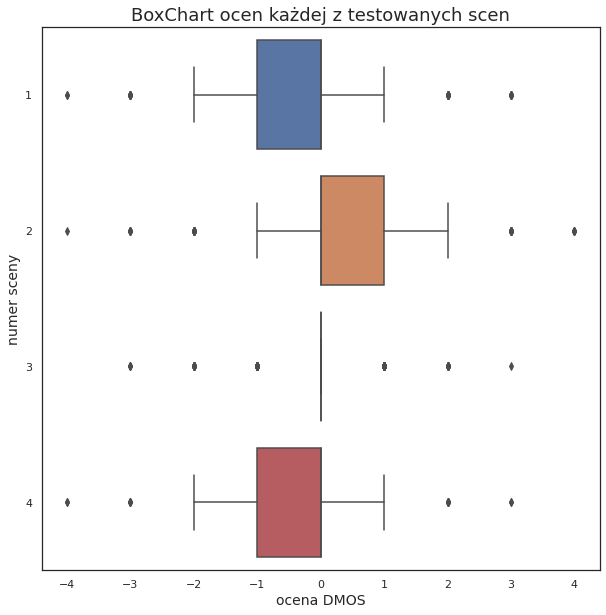

In [ ]:
oceny_s1 = []
oceny_s2 = []
oceny_s3 = []
oceny_s4 = []

# oceny_s1 = dmos.loc[(dmos["scena"]==1) & (dmos["funkcja"]==2)]["DMOS"]
# oceny_s2 = dmos.loc[(dmos["scena"]==2) & (dmos["funkcja"]==2)]["DMOS"]
# oceny_s3 = dmos.loc[(dmos["scena"]==3) & (dmos["funkcja"]==2)]["DMOS"]
# oceny_s4 = dmos.loc[(dmos["scena"]==4) & (dmos["funkcja"]==2)]["DMOS"]

oceny_s1 = dmos.loc[(dmos["scena"]==1)]["DMOS"]
oceny_s2 = dmos.loc[(dmos["scena"]==2)]["DMOS"]
oceny_s3 = dmos.loc[(dmos["scena"]==3)]["DMOS"]
oceny_s4 = dmos.loc[(dmos["scena"]==4)]["DMOS"]

# oceny_s4.to_excel ('_data4.xlsx', index = False, header=True)

#test Levene na jednorodność wariancji:, jak p-value wyjdzie mniejsze niż 0,05 to nie są jednorodne:
# if stats.levene(oceny_s1, oceny_s2, oceny_s3, oceny_s4).pvalue > 0.05:
#   print("Brak istotnej różnicy wariancji pomiędzy grupami")

from scipy.stats import f_oneway
f_oneway(oceny_s1, oceny_s2, oceny_s3, oceny_s4)

if f_oneway(oceny_s1, oceny_s2, oceny_s3, oceny_s4).pvalue < 0.05:
  print("Spełnione")


# import statsmodels.api as sm
# from statsmodels.formula.api import ols

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
ax = sns.boxplot(x="DMOS", y="scena", data=dmos, orient='h', dodge=False)


ax.axes.set_title("BoxChart ocen każdej z testowanych scen", fontsize=18)
ax.set_xlabel("ocena DMOS", fontsize=14)
ax.set_ylabel("numer sceny", fontsize=14)



**Wykres pudełkowy ocen każdego pliku testowego**

Text(0, 0.5, 'nazwa pliku gif')

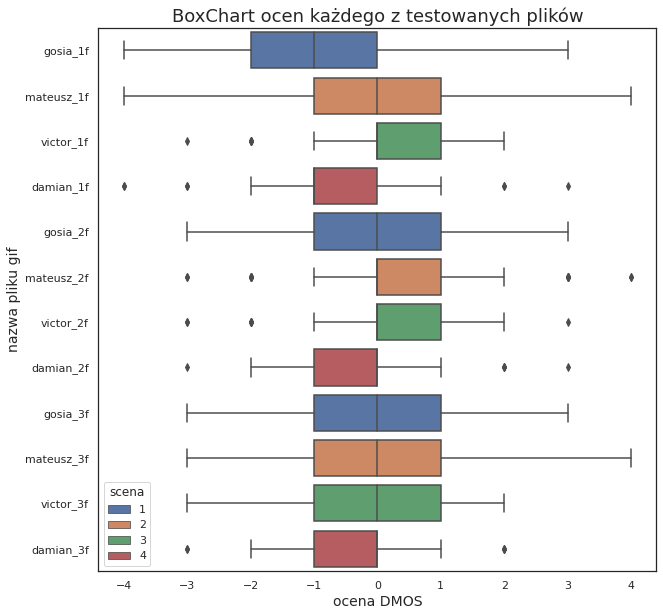

In [ ]:
dmos2 = dmos[dmos["funkcja"] != 0]

my_order = ["gosia_1f", "mateusz_1f", "victor_1f", "damian_1f", "gosia_2f", "mateusz_2f", "victor_2f", "damian_2f", "gosia_3f", "mateusz_3f", "victor_3f", "damian_3f"]
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
ax = sns.boxplot(x="DMOS", y="gif_nazwa", hue="scena", data=dmos2, orient='h', order = my_order, dodge=False)

ax.axes.set_title("BoxChart ocen każdego z testowanych plików", fontsize=18)
ax.set_xlabel("ocena DMOS", fontsize=14)
ax.set_ylabel("nazwa pliku gif", fontsize=14)



**Wykres pudełkowy ocen trzech funkcji**

Text(0, 0.5, 'testowana funkcja')

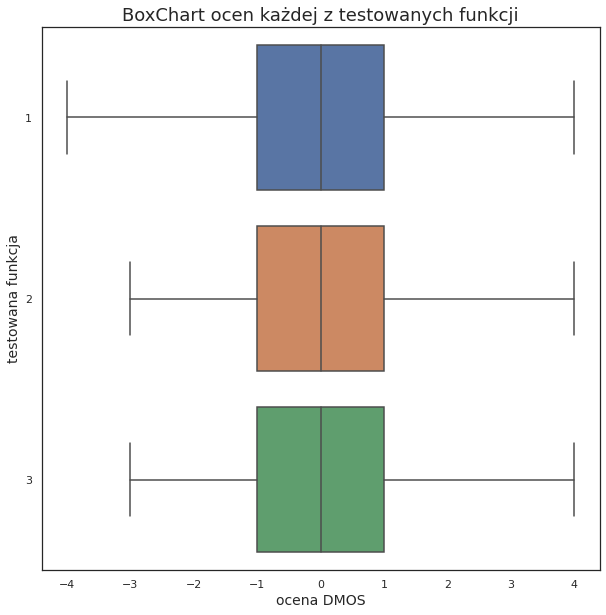

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
ax = sns.boxplot(x="DMOS", y="funkcja", data=dmos2, orient='h', dodge=False)

ax.axes.set_title("BoxChart ocen każdej z testowanych funkcji", fontsize=18)
ax.set_xlabel("ocena DMOS", fontsize=14)
ax.set_ylabel("testowana funkcja", fontsize=14)